##### this example file works with NS.py (11/07/2019)

## Packages

In [44]:

import numpy as np
import os
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    import matplotlib as mpl
    mpl.use('Agg')
    FLAG_TQDM = False
    flag_argparse = True
else:
    FLAG_TQDM = True
    try:
        get_ipython().config 
        from tqdm import tqdm_notebook as tqdm
        print('currently on local notebook')
        flag_argparse = False
        # call init() on notebook to set global variables
    except NameError:
        from tqdm import tqdm # status bar
        print('currently on local')
        flag_argparse = True

def init(S,D):
    global s
    global diam_narrow
    s = S
    diam_narrow = D

import matplotlib.pyplot as plt
import subprocess
# mesh
from mshr import * 
# FEM solver
from dolfin import * 
import sys
from scipy.interpolate import interp1d
import argparse

u0 = 1#20#2.                 # init amplitude
# # symmetry!!!!!!!!!!
# global s 
# # s = 0.#.5                  # init asymmetry
# #shrink!!!!!!!!!!!!!
# global diam_narrow
# # diam_narrow=0.004#0.02

if flag_argparse:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', help="symmetry", type= float)
    parser.add_argument('-diam_narrow', '-d', type= float, help="diam_narrow")
    args=parser.parse_args()
    # print(args)
    if args.s:  
        pass
    if args.diam_narrow:
        pass
    # global s
    # global diam_narrow
    s=args.s
    diam_narrow=args.diam_narrow

diam_steno_vessel=0.1
theta_steno=np.pi/6
diam_healthy_vessel=0.1
theta_healthy=np.pi/6
length0 = .5
length = .3
length_steno  = .2 # 2*diam_steno_vessel                      # Length of stenosis
diam_trunk = diam_healthy_vessel * np.cos(theta_healthy) + diam_steno_vessel * np.cos(theta_steno)
mesh_precision = 30
#physics
mu = 0.03
rho = 1

currently on local notebook


## Parameters

In [25]:

u0 = 1#20#2.                 # init amplitude
# symmetry!!!!!!!!!!
global s 
s = 0.3#.5                  # init asymmetry
#shrink!!!!!!!!!!!!!
global diam_narrow
diam_narrow=0.03#0.02


diam_steno_vessel=0.1
theta_steno=np.pi/6
diam_healthy_vessel=0.1
theta_healthy=np.pi/6
length0 = .5
length = .3
length_steno  = .2 # 2*diam_steno_vessel                      # Length of stenosis
diam_trunk = diam_healthy_vessel * np.cos(theta_healthy) + diam_steno_vessel * np.cos(theta_steno)
mesh_precision = 30
#physics
mu = 0.03
rho = 1

#old geometry
sqr2 = 2**.5    #constant for simplicity
Y0 = 2          #Y trunk length
Y1 = 2 * sqr2   #Y branch length
y1 = 2          
Y2 = 2 * sqr2   #Y branch length
y2 = 2
D = .1 * sqr2   #branch radius
d = .1
D0 = 2*d        #trunk radius
A = .5          #shrink length = 2A
a = A / sqr2
B = .0          #shrink width = B
b = B / sqr2

# # windkessel,
c = 1#1.6e-5              # distant capacitance
Rd = 1#6001.2             #1e5 #6001.2 distant resistance
Rp = 1#7501.5             #5e4 #7501.5 proximal resistance
p_windkessel_1 = 1#1.06e5 #1.06e5 # init val, large number could lead to overflow
p_windkessel_2 = 1#1.06e5 #1.06e5 # init val

## Utilities

In [35]:
import NS
# from importlib import reload
# NS = reload(NS)
NS.init(s,diam_narrow)

## Plot Mesh

In [36]:
artery = NS.Artery(diam_steno_vessel, diam_narrow, theta_steno, diam_healthy_vessel, theta_healthy)
mesh_precision = 50
mesh = artery.mesh(mesh_precision)
# File('NSdata/artery.xml.gz') << mesh
# mesh = Mesh('NSdata/artery.xml.gz')
mesh


## Tutorial of NS.py (see also \_\_main\_\_ scripts)

In [37]:

T = .5
critical_time = 0.46
num_steps = 250
flag_movie = True
flag_cleanup = False 
flag_xray = True
flag_diagnosis = True
flag_IPCS = True
with_teman = False
with_bf_est = False
plot_during_solving = False
flag_tqdm = FLAG_TQDM
freq_plot = 1
uname = 'NSdata/u_series'
pname = 'NSdata/p_series'
u,p= NS.compute_NSsolution_IPCS(mesh,
        T=T,
        num_steps=num_steps,
        mu=mu,
        rho=rho,
        c=c,
        Rd=Rd,
        Rp=Rp,
        p_windkessel_1=p_windkessel_1,
        p_windkessel_2=p_windkessel_2,
        u0=u0,
        s = s,
        uname = uname,
        pname = pname,
        flag_tqdm = FLAG_TQDM,
        plot_during_solving = plot_during_solving
        # flag_movie=flag_movie
        )

t = 0.5000 u_max: 21.62, p_max: 24.75 : : 0.5000000000000003it [01:28, 156.03s/it]                        


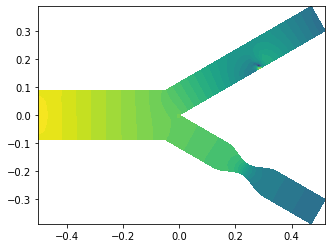

In [41]:
plot(p)

## A compact solver

In [42]:
T = .5
critical_time = 0.46
num_steps = 250
dt = T / num_steps
### Define function spaces
V, Q = NS.compute_space_IPCS(mesh)
#### Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
#### Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)
#### Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)
inflow_expr = NS.INFLOW(u0,s,diam_steno_vessel, theta_steno, diam_healthy_vessel, theta_healthy,degree=2)
#### Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))
#### Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))
#### Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)
#### Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx
#### Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx
#### Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)
# tol=.001
# Points:
### Flux surface for u
# p1_healthy, p2_healthy = find_endpoint(length*2,0,diam_healthy_vessel,-theta_healthy)
# p2_steno, p1_steno = find_endpoint(length*2,-diam_steno_vessel,0,theta_steno)
### Time-stepping
t = 0.0
pbar = tqdm(total=T)
for n in range(num_steps):
    # Update current time
    t += dt
    bcu, bcp = NS.compute_bc(V,Q,t,0,0,u0,s,inflow_expr,NS.inflow_domain,NS.heartfun,)
    [bc.apply(A1) for bc in bcu]
    [bc.apply(A2) for bc in bcp]
    [bc.apply(A3) for bc in bcu]
    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    [bc.apply(b1) for bc in bcp]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')
    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')
    # Step 3: Velocity correction step
    b3 = assemble(L3)
    [bc.apply(b3) for bc in bcu]
    # [bc.apply(b3) for bc in bcp]
    solve(A3, u_.vector(), b3, 'cg', 'sor')
#     # Save nodal values to file
#     timeseries_u.store(u_.vector(), t)
#     timeseries_p.store(p_.vector(), t)
    # Update previous solution
    p_n.assign(p_)
    u_n.assign(u_)
    pbar.update(dt)
    pbar.set_description("t = %.4f" % t + 'u_max:%.2f, ' % u_.vector().vec().max()[1] + 'p_max:%.2f ' % p_.vector().vec().max()[1])
    
pbar.close()

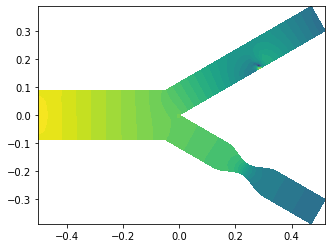

In [46]:
plot(p_)